In [91]:
import soundfile as sf
import numpy as np
from scipy import stats
import matplotlib as plt
import torch
from fairseq.models.wav2vec import Wav2VecdecoderModel, Wav2VecAutoEncoderModel

In [3]:
import soundfile as sf
import numpy as np
from scipy import stats
import matplotlib as plt

fname = '/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/116-288045-0000.flac'
# fname = '/home/thn/audio_dataset/LibriSpeech/dev-clean/174/50561/174-50561-0000.flac'

wav, curr_sample_rate = sf.read(fname)
# feats = torch.from_numpy(wav).float()
wav_t = wav *5 /3 + 0.5
source = torch.from_numpy(wav).float().view(1, -1)

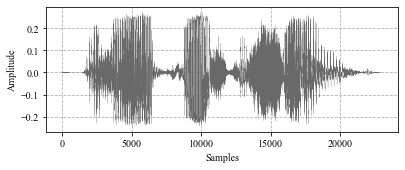

In [319]:
save_curve((source.view(-1)[7000:30000]).detach().numpy(), 'fig_source_0720.png')

### load model 

In [132]:
# ./w2v_thn/decoder/0118like_en_arch/checkpoint_last.pt
# './w2v_thn/0119_big_lr/checkpoint_best.pt'
# './w2v_thn/decoder/0119_big_lr_small_sample/checkpoint_last.pt'
# cp = torch.load('./w2v_thn/decoder/0221_1_act_tanh_time_div4_feat8_6dB_MSE/checkpoint_best.pt')
cp = torch.load('./w2v_thn/Rice_decoder/0623_tanh_tdiv1_feat8_6dB_Rice0_8_NR/checkpoint_last.pt')

model = Wav2VecAutoEncoderModel.build_model(cp['cfg']['model'], task=None)
model.load_state_dict(cp['model'])
model.eval()

Wav2VecAutoEncoderModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): ConvTranspose1d(8, 8, kernel_size=(1,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 8, eps=1e-05, affine=True)
      )
      (1): Sequential(
        (0): ConvTranspose1d(8, 8, kernel_size=(2,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 8, eps=1e-05, affine=True)
      )
      (2): Sequential(
        (0): ConvTranspose1d(8, 8, kernel_size=(4,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 8, eps=1e-05, affine=True)
      )
      (3): Sequential(
        (0): ConvTranspose1d(8, 1, kernel_size=(1,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Tanh()
      )
    )
  )
  (feature_aggregator): ConvAggegator(
    (conv_layers): Sequential(
      (0): Seq

In [329]:
# Encoder, Transmitter 
source_ = source 
T_a = model.feature_extractor_en(source_)
T_a_ = model.dropout_feats_en(T_a)
print("|*****T_a_S:|", T_a_.shape)
X = model.feature_aggregator_en(T_a_)
X = model.dropout_agg_en(X)
print("|*******X_S:|", X.shape)

# Channel layer

import math
import numpy as np
SNR = 6 # dB # SNR = 10 log（s/n） = 6
P_noise = 0.2 /math.sqrt(10**(SNR/10))
P_noise = torch.tensor(P_noise).half()
# [r1,r2,r3] = X.shape 
# noise = np.random.randn(r1,r2,r3)
noise = torch.randn(X.shape).half()
# print(X.type(), torch.from_numpy(noise).float().cuda().type(), P_noise.type())
# Y = X + torch.from_numpy(noise).half().cuda() * P_noise.cuda()
Y = 1 *( X + noise * P_noise)

# —————————— No Noise Channel ————————-
# Y  = X

# ——————————  Decoder, Receiver ———————
print("In the Channel Y_S", Y.shape)
features = model.feature_aggregator(Y)
# x = self.dropout_agg(feature)

features_ = model.dropout_agg(features)
x = model.feature_extractor(features_)
print("|in decoder model, out feature_extractor|", x.shape)
x_ = model.dropout_feats(x)
# x_ = x_ - 1

|*****T_a_S:| torch.Size([1, 8, 170396])
|*******X_S:| torch.Size([1, 8, 170396])
In the Channel Y_S torch.Size([1, 8, 170396])
|in decoder model, out feature_extractor| torch.Size([1, 1, 170400])


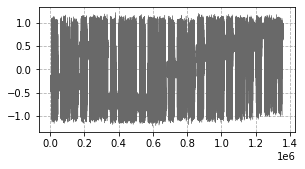

In [291]:
plot_curve((Y.view(-1)).detach().numpy())# original output

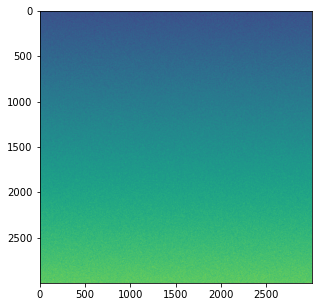

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np

z = (np.random.rand(9000000)+np.linspace(0,1, 9000000)).reshape(3000, 3000)*2

plt.imshow(z)
# #            )
# plt.rcParams['figure.figsize'] = (5.0, 5.0) # 设置figure_size尺寸

# plt.colorbar(fraction=0.0135, pad=0.05, norm=LogNorm(10))


# plt.xticks(fontsize=15, family='Times New Roman')
# plt.yticks(fontsize=15, family='Times New Roman')


In [13]:
z.min()

0.00022222506763652916

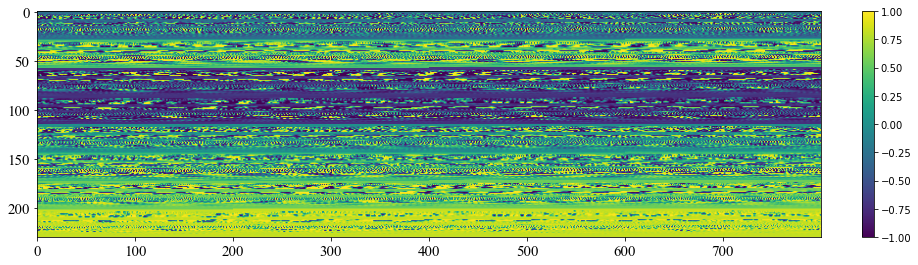

In [90]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np
# x, y = np.random.rand(10), np.random.rand(10)
# z = (np.random.rand(9000000)+np.linspace(0,1, 9000000)).reshape(3000, 3000)

_X_ = X[0,range(8),7000:30000].view(-1,800)
plt.imshow(_X_.detach().numpy()  )
#            norm=LogNorm(1))
plt.rcParams['figure.figsize'] = (15.0, 15.0) # 设置figure_size尺寸

plt.colorbar(fraction=0.0135, pad=0.05)


plt.xticks(fontsize=15, family='Times New Roman')
plt.yticks(fontsize=15, family='Times New Roman')


# plt.figure(figsize=(4,3))

# plt.colorbar()


plt.savefig('fig_transmitted_0720.eps', dpi =100)
plt.show()

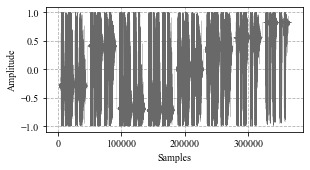

In [293]:
save_curve((X[0][range(8),4000:50000].view(-1)).detach().numpy(),'fig_received.eps')

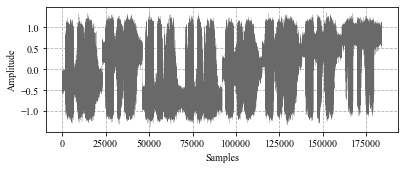

In [326]:
save_curve((Y[0][range(8),7000:30000].view(-1)).detach().numpy(), 'fig_received_0802.png')

In [110]:
save_curve((Y[0][range(8),7000:30000].view(-1)).detach().numpy(), 'fig_received_0720.eps')

IndexError: index 6 is out of bounds for dimension 0 with size 4

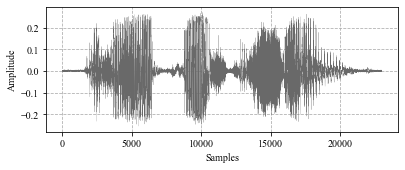

In [330]:
save_curve((x_.view(-1)[7000:30000]).detach().numpy(), 'fig_decoded_0802.png')    # original output

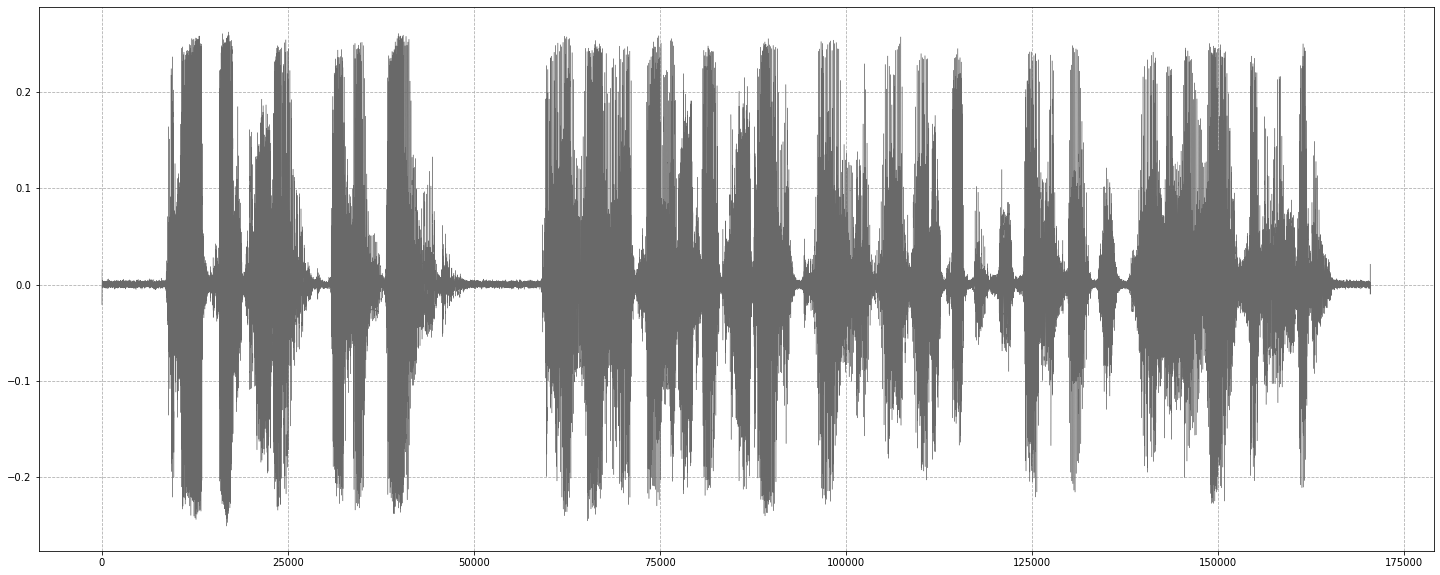

In [102]:
plot_curve((x_.view(-1)).detach().numpy())# original output

SyntaxError: invalid syntax (<ipython-input-17-28e9fe1b8fc8>, line 1)

In [101]:
#  定义绘制一维向量的函数
def plot_curve(y: np.ndarray, i = 0, j = 0) -> None:
    import matplotlib.pyplot as plt
    import matplotlib
    x = np.arange(0,len(y))
    if j == 0: 
        j = len(y)      
    # i = 10000
    # l = 50000
    plt.figure(1)
    plt.plot(x[i: i + j], y[i: i + j],'k',color='#696969', linewidth=0.4, linestyle="-") 
    plt.rcParams['figure.figsize'] = (50.0, 10.0) # 设置figure_size尺寸
    plt.grid(ls='--')#标尺，on：有，off:无。
#     plt.savefig('fig_source.eps', dpi=600, format='eps')
#     plt.savefig('fig_source.png')
    plt.show() #展示绘图


In [317]:
#  定义绘制一维向量的函数
def save_curve(y: np.ndarray, fig_name: str) -> None:
    import matplotlib.pyplot as plt
    import matplotlib
    i = 0
    j = 0
    x = np.arange(0,len(y))
    if j == 0: 
        j = len(y)      
    # i = 10000
    # l = 50000
    plt.figure(1)
    plt.plot(x[i: i + j], y[i: i + j],'k',color='#696969', linewidth=0.2, linestyle="-") 
    plt.rcParams['figure.figsize'] = (6.3, 2.3) # 设置figure_size尺寸
    plt.grid(ls='--')#标尺，on：有，off:无。
    
#     plt.title('显示中文标题') 标题


    plt.xlabel("Samples", fontsize=10, family='Times New Roman')
    plt.xticks(fontsize=10, family='Times New Roman')
    plt.ylabel("Amplitude", fontsize=10, family='Times New Roman')
    plt.yticks(fontsize=10, family='Times New Roman')

    plt.savefig(fig_name, dpi=300, format='png')
#     plt.savefig('fig_source.png')
    plt.show() #展示绘图
